In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
df = pd.read_csv('dao_maker_launches_cleaned.csv', sep='\t').drop(['Unnamed: 0'], axis=1)
# choose relevant columns
# get dummy data
# train test split
# multiple linear regression
# lasso regression
# random forest
# svr regression
# tune models using GridsearchCV
# test ensembles
df.columns

Index(['name', 'money_raised', 'ATH_ROI', 'catg', 'VC', 'MM', 'cap_controlled',
       'dao_approved', 'cg_id', 'launch_date', 'chain', 'btc_fg_index',
       'launch_month', 'desc', 'desc_len', 'token_ratio', 'marketing_ratio',
       'user_ratio'],
      dtype='object')

In [4]:
# choosing columns
df_model = df[['money_raised', 'ATH_ROI', 'catg', 'VC', 'MM', 'cap_controlled',
       'dao_approved', 'chain', 'btc_fg_index','launch_month', 'desc_len', 
        'token_ratio', 'marketing_ratio', 'user_ratio']]

In [5]:
# get dummies
df_dummy = pd.get_dummies(df_model)

In [6]:
# train test split
from sklearn.model_selection import train_test_split
X = df_dummy.drop(['ATH_ROI'], axis=1).values
y = df_dummy['ATH_ROI'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

-38.0695426555106


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.214e+04, tolerance: 1.572e+01
  model = cd_fast.enet_coordinate_descent(


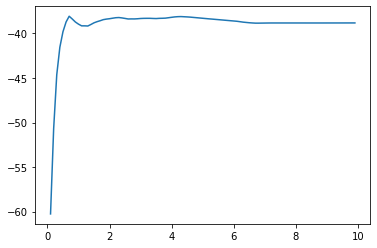

In [7]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score

# Lasso regression
lm_l = Lasso(alpha=0.7).fit(X_train, y_train)

print(np.mean(cross_val_score(lm_l, X_train, y_train, scoring='neg_mean_absolute_error', cv=3)))

alpha = []
error = []

for i in range(1,100):
    alpha.append(i/10)
    lm_l2 = Lasso(alpha=(i/10))
    error.append(np.mean(cross_val_score(lm_l2, X_train, y_train, scoring='neg_mean_absolute_error', cv=3)))

    
plt.plot(alpha, error)

In [8]:
err = tuple(zip(alpha, error))
max(err, key = lambda x: x[1])

(0.7, -38.0695426555106)

In [9]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(criterion='absolute_error', max_depth=5,
                      max_features='log2', n_estimators=10)
rf.fit(X_train, y_train)

np.mean(cross_val_score(rf, X_train, y_train, scoring='neg_mean_absolute_error', cv=3))

-35.28183333333333

In [87]:
# tune Random forest with GridSearch
from sklearn.model_selection import GridSearchCV

parameters = {'n_estimators': range(10,300, 10), 'criterion': ('squared_error', 'absolute_error', 'poisson'), 
              'max_features': ('auto', 'sqrt', 'log2'), 'max_depth': range(1,10,2)}

gs = GridSearchCV(rf, param_grid=parameters, scoring='neg_mean_absolute_error', cv=3)
gs.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'criterion': ('squared_error', 'absolute_error',
                                       'poisson'),
                         'max_depth': range(1, 10, 2),
                         'max_features': ('auto', 'sqrt', 'log2'),
                         'n_estimators': range(10, 300, 10)},
             scoring='neg_mean_absolute_error')

In [100]:
# RandomForestRegressor(criterion='absolute_error', max_depth=5,
#                       max_features='log2', n_estimators=10)

print(gs.best_score_)
print(gs.best_estimator_)

-32.2308611111111
RandomForestRegressor(criterion='absolute_error', max_depth=5,
                      max_features='log2', n_estimators=10)


In [10]:
# SVR
from sklearn.svm import SVR

svr = SVR(C=100).fit(X_train, y_train)

np.mean(cross_val_score(svr, X_train, y_train, scoring='neg_mean_absolute_error', cv=3))

-33.306958784258335

In [99]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': ['scale', 'auto'],
              'kernel': ['rbf', 'linear']}

gs_svc = GridSearchCV(svr, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=3, verbose=2)
gs_svc.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   7.9s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=  10.6s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=  11.2s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   8.1s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=  10.9s
[CV] END ...................C=0.1, gamma=auto, k

GridSearchCV(cv=3, estimator=SVR(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['rbf', 'linear']},
             scoring='neg_mean_absolute_error', verbose=2)

In [101]:
# SVR(C=100)
print(gs_svr.best_score_)
print(gs_svr.best_estimator_)

-33.30709571350865
SVR(C=100)


In [11]:
tpred_lml = lm_l.predict(X_test)
tpred_rf = rf.predict(X_test)
tpred_svr = svr.predict(X_test)

In [48]:
from sklearn.metrics import mean_absolute_error
print("Lasso Regression: {}".format(mean_absolute_error(y_test, tpred_lml)))
print("Random Forest: {}".format(mean_absolute_error(y_test, tpred_rf)))
print("SVR: {}".format(mean_absolute_error(y_test, tpred_svr)))

Lasso Regression: 58.126310261556156
Random Forest: 33.794736842105266
SVR: 28.68643334761664


In [55]:
sorted(list(zip(svr.coef_, df_dummy.drop(['ATH_ROI'], axis=1).columns)))[-10:]

[(12.064091176199268, 'catg_DeFi'),
 (13.744343226259232, 'VC_ Lucid Blue '),
 (17.237190451876632, 'catg_other'),
 (18.020560264606935, 'VC_ DAO Maker '),
 (20.41124924964125, 'cap_controlled'),
 (21.751804582350193, 'MM_other'),
 (23.672833825780735, 'VC_other'),
 (25.991572313802184, 'dao_approved'),
 (32.21370295193037, 'chain_ethereum'),
 (74.15686635570712, 'catg_Metaverse')]

In [13]:
import pickle
pickl = {'model': svr}
pickle.dump( pickl, open( 'model_file' + ".p", "wb") )

file_name = "model_file.p"
with open(file_name, 'rb') as pickled:
    data = pickle.load(pickled)
    model = data['model']

In [62]:
model.predict(X_test[1,:].reshape(1,-1))

array([21.46122166])

In [100]:
max(df_dummy['ATH_ROI'])

352